In [321]:
import numpy as np
import pylab as plt
from scipy.linalg import logm
import corner
import scipy.stats as stat
from matplotlib.patches import Ellipse
plt.style.use('classic')
%matplotlib inline

# 1
I use this equation to describe each object which i assume to be circularly Gaussian shaped

$\tau((x,y);[X,Y,A,R]) = Aexp[-\frac{(x-X)^2+(y-Y)^2}{2R^2}]$  (reference: M.P Hobson and C. McLachlan paper)

In [322]:
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

In [334]:
# Position x,y
x = np.arange(0, 200, 1, float)
y = x[:,np.newaxis]
# Source1 
X1 = 100
Y1 = 50
R1 = 5
A1 = 4


source1_template = tau(x,y,X1,Y1,R1,A1) 

In [336]:
noise = np.random.normal(2,0.5,source1_template.shape)
Source = source1_template  + noise

# 2


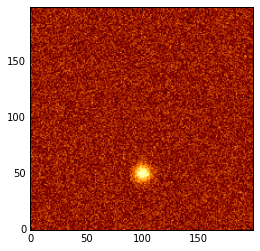

In [337]:
plt.figure()
plt.imshow(Source,origin='lower',cmap='afmhot',)

# 3

 - I then define my Model (Which is the template equation defined in 1) and my Likelihood (Gaussian function)
 - So my data in this case is the simulated template values in part 1 


In [338]:
def Model(x,y,Xm,Ym,Rm,Am):  #Model
    x = np.arange(0, 200, 1, float)
    y = x[:,np.newaxis]
    
    source_template = tau(x,y,Xm,Ym,Rm,Am)
    return source_template

In [339]:
def logLike(Xm,Ym,Rm,Am): #Likelihood function
    
    data = Source
    mu = Model(x,y,Xm,Ym,Rm,Am)
    LogL = -(len(data)/2)*np.log(2*np.pi)-(len(data)/2)*np.log(2**2)-(1/(2*(2**2)))*(np.sum((data-mu)**2))
    
    return LogL 

In [406]:
#Initial values  
theta = [70,40,3,2]   # Random start sample
interval = [(0,200),(0,200),(1,6),(1,6)]  #Unifotm prior on parameters
nmcmc_runs = 10000                      #Number  of mcmc runs
samples_mcmc = np.zeros((nmcmc_runs,4))  #Store samples
sigma = [5,5,2.5,1.5]                       # sigma for proposal jump

In [407]:
naccepted = 0
for i in range(nmcmc_runs):
    theta_new = theta + np.random.normal(0,sigma)  # Proposed new sample 
    
    while True:  #check is sample lies within flat prior
        add = 0
        for j in range(4):
            if interval[j][0] <= theta_new[j] <= interval[j][1]:
                add  += 1
        if add == 4: #if true Prior = 1
            Prior = 1
            break
            
        else:          #If false Prior = 0
            Prior = 0
            
            break
            
    
    logLikelihood_proposed = logLike(theta_new[0],theta_new[1],theta_new[2],theta_new[3])*Prior #Proposed Liklelihood
    logLikelihood_current = logLike(theta[0],theta[1],theta[2],theta[3])                        #Current likelihood
    
    alpha = logLikelihood_proposed/logLikelihood_current 
    
    if alpha >= 1:            #Accept if new sample has higher likelihood
        theta = theta_new
        naccepted += 1
    else:                   # If not, randomly reject or accept sample 
        u = np.random.uniform() # Generate random uniform value between u~[0,1]
        if u <= alpha :           #if alpha is larger than u, accept sample
            theta = theta_new
            naccepted +=1
        else:                #if not reject sample
            theta = theta    
    
    samples_mcmc[i,:] = theta_new   #Store samples
    

In [408]:
print('Efficiency:',naccepted/len(samples_mcmc))

Efficiency: 0.4451


## 4 Posterior Results

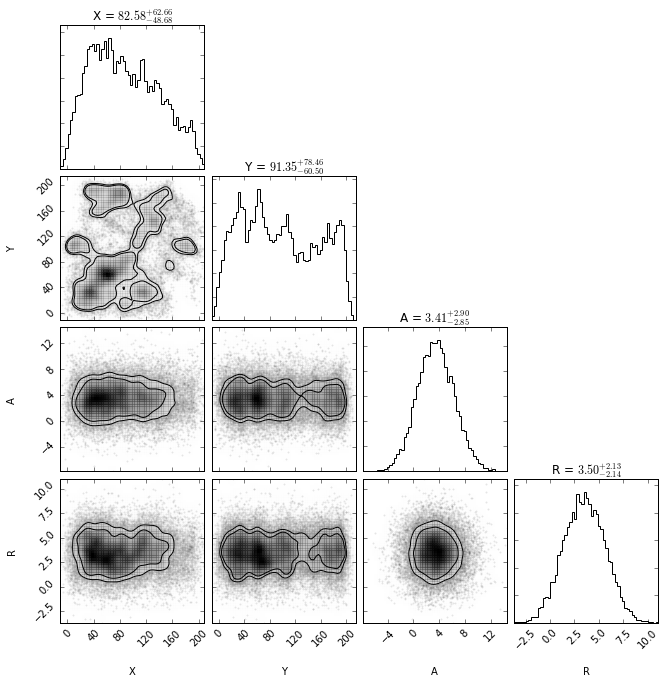

In [409]:
corner.corner(samples_mcmc,labels=['X','Y','A','R'],show_titles=True,bins=60,levels=[0.5,0.65],smooth=1.7,max_n_ticks=7);


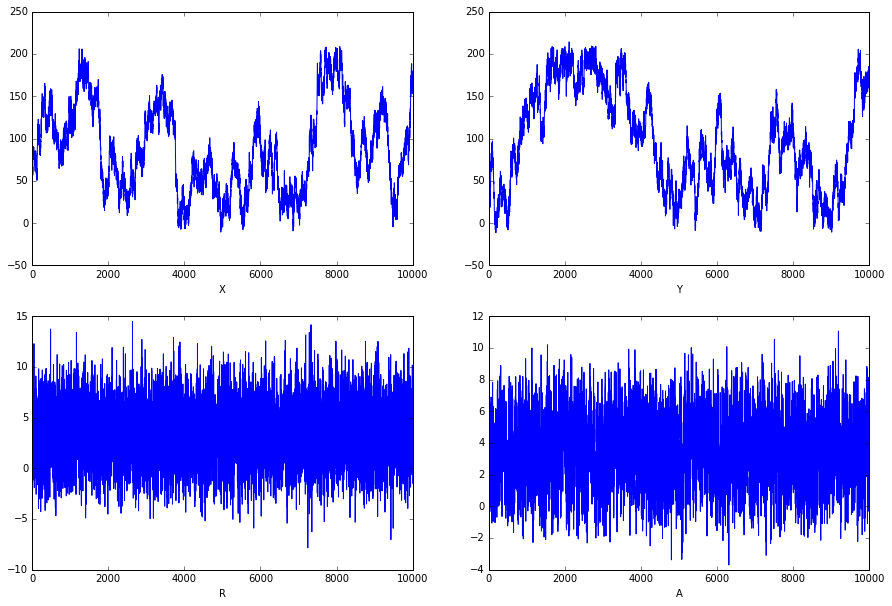

In [410]:
plt.figure(figsize=(15,10))

labels = ['X','Y','R','A']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(samples_mcmc[:,i])
    plt.xlabel(labels[i])



## 5

I decided to plot an ellipse centred at the estimated position of the source with arbitrary height and width.

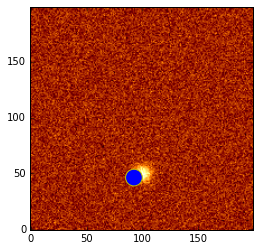

In [229]:
plt.figure()
ax = plt.gca()

ellipse = Ellipse(xy=(92.45,46.3),width=15,height=15,edgecolor='y')
ax.add_patch(ellipse)

ax.imshow(Source,origin='lower',cmap='afmhot',)

    X_estimate = 4.58     X_real = 5
    Y_estimate = 4.50     Y_real = 5
    A_estimate = 0.74     A_real = 0.96
    R_estimate = 85.2     R_real = 100

In [ ]:
print('X_err = {},\nY_err = {},\nA_err= {},\nR_err = {}'.format(np.std(samples_mcmc[:,0]),np.std(samples_mcmc[:,1]),np.std(samples_mcmc[:,2]),np.std(samples_mcmc[:,3])))